#### Analyzing Neural Time Series Data
Python code for Chapter 15 -- converted from original Matlab by AE Studio (and ChatGPT)\
Original Matlab code by Mike X Cohen

This code accompanies the book, titled "Analyzing Neural Time Series Data" (MIT Press).\
Using the code without following the book may lead to confusion, incorrect data analyses, and misinterpretations of results.\
Mike X Cohen and AE Studio assume no responsibility for inappropriate or incorrect use of this code.

In [3]:
# Import necessary libraries
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import detrend
from scipy.fft import fft
from scipy.io import loadmat

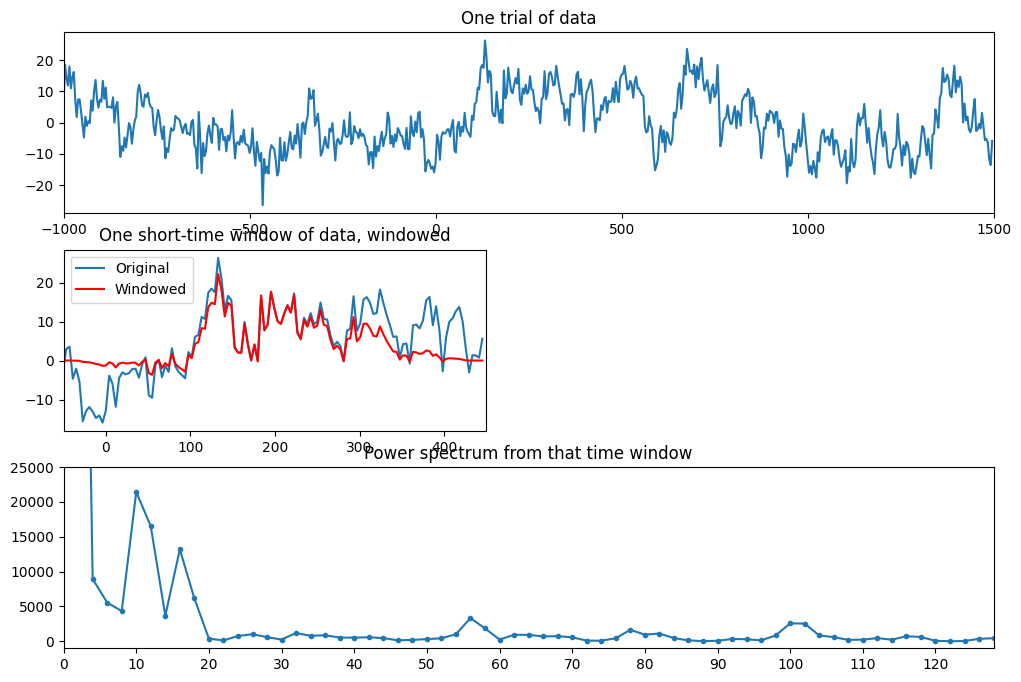

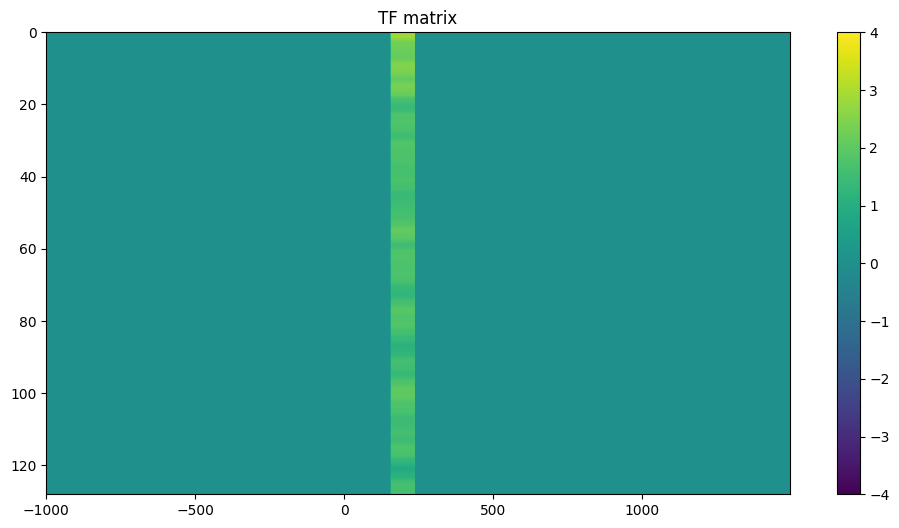

In [15]:
# Load sample EEG data
EEG = loadmat('../data/sampleEEGdata.mat')['EEG'][0, 0]

# Define time window in ms
timewin = 500

# Convert ms to index
timewinidx = round(timewin / (1000 / EEG['srate'][0][0]))

# Create Hann taper function
hann_win = 0.5 * (1 - np.cos(2 * np.pi * np.arange(timewinidx) / (timewinidx - 1)))

# Detrend data
d = detrend(EEG['data'][19, :, 15])

# Plot one trial of data
plt.figure(figsize=(12, 8))
plt.subplot(311)
plt.plot(EEG['times'][0], d)
plt.xlim([-1000, 1500])
plt.title('One trial of data')

# Find the sample time closest to -50 ms
stime = np.argmin(np.abs(EEG['times'][0] - (-50)))

# Plot one short-time window of data, windowed
plt.subplot(323)
plt.plot(EEG['times'][0][stime:stime + timewinidx], d[stime:stime + timewinidx], label='Original')
plt.plot(EEG['times'][0][stime:stime + timewinidx], d[stime:stime + timewinidx] * hann_win, 'r', label='Windowed')
plt.xlim([-50, -50 + timewin])
plt.title('One short-time window of data, windowed')
plt.legend()

# Compute power spectrum from that time window
dfft = fft(d[stime:stime + timewinidx] * hann_win)
f = np.linspace(0, EEG['srate'][0][0] / 2, int(np.floor(len(hann_win) / 2)) + 1)
plt.subplot(313)
plt.plot(f[1:], np.abs(dfft[1:int(np.floor(len(hann_win) / 2)) + 1]) ** 2, '.-')
plt.title('Power spectrum from that time window')
plt.xlim([1, 128])
plt.ylim([-1000, 25000])
plt.xticks(np.arange(0, EEG['srate'][0][0] / 2 + 1, 10))

# Create TF matrix and input column of data at selected time point
tf = np.zeros((int(np.floor(len(hann_win) / 2)), EEG['pnts'][0][0]))
tf[:, stime + int(timewinidx / 2) - 11:stime + int(timewinidx / 2) + 10] = np.tile(np.abs(dfft[1:int(np.floor(len(hann_win) / 2)) + 1]) * 2, (21, 1)).T

# Plot TF matrix
plt.figure(figsize=(12, 6))
plt.imshow(np.log10(tf + 1), aspect='auto', extent=[EEG['times'][0][0], EEG['times'][0][-1], f[0], f[-1]], origin='lower')
plt.gca().invert_yaxis()
plt.clim([-4, 4])
plt.colorbar()
plt.title('TF matrix')
plt.show()


Overlap of 87.5%


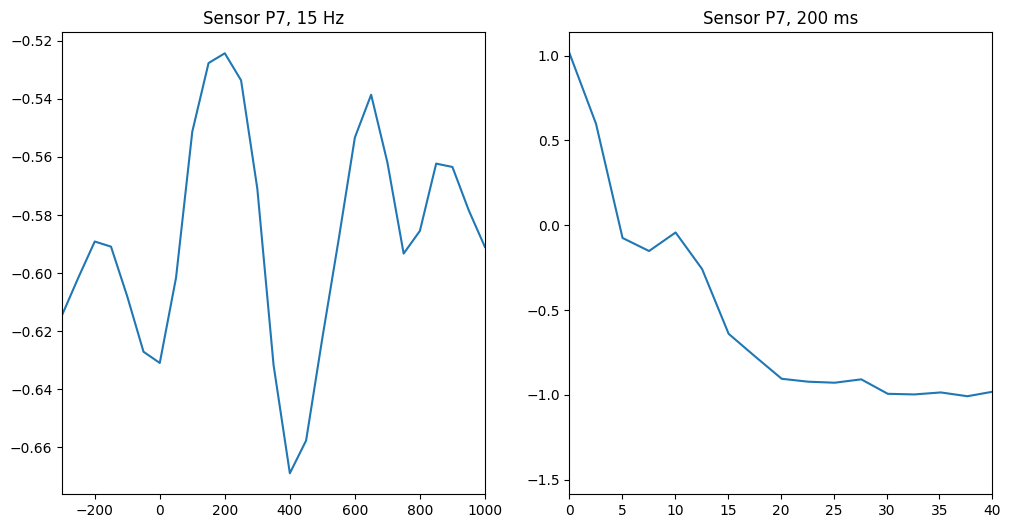

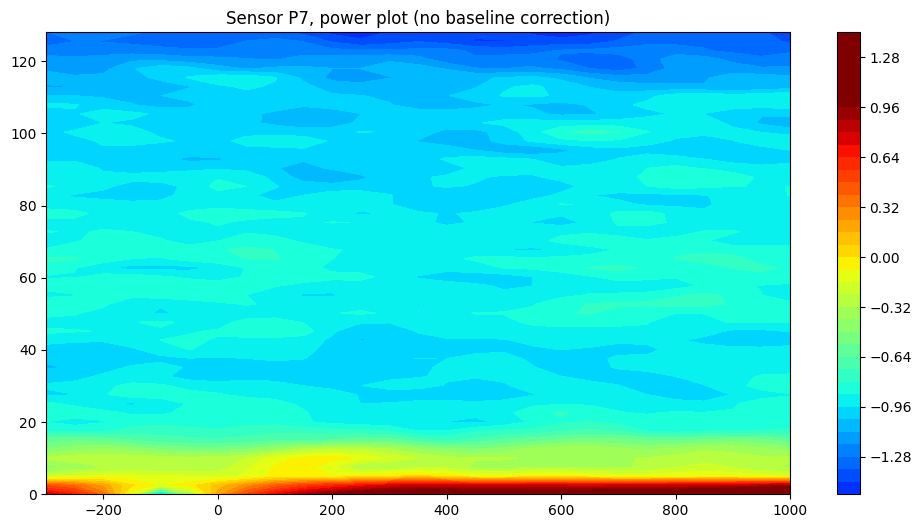

In [35]:
# Define parameters for Figure 15.2
timewin = 400  # in ms, for stFFT
times2save = np.arange(-300, 1050, 50)  # in ms
channel2plot = 'P7'
frequency2plot = 15  # in Hz
timepoint2plot = 200  # ms

# Convert from ms to index
times2saveidx = [np.argmin(np.abs(EEG['times'][0] - t)) for t in times2save]
timewinidx = round(timewin / (1000 / EEG['srate'][0][0]))
chan2useidx = np.where(np.array([ch['labels'][0] for ch in EEG['chanlocs'][0]]) == channel2plot)[0][0]

# Create Hann taper
hann_win = 0.5 * (1 - np.cos(2 * np.pi * np.arange(timewinidx) / (timewinidx - 1)))

# Define frequencies
frex = np.linspace(0, EEG['srate'][0][0] / 2, int(np.floor(timewinidx / 2)) + 1)

# Initialize power output matrix
tf = np.zeros((len(frex), len(times2save)))

# Loop over time points and perform FFT
for timepointi, tidx in enumerate(times2saveidx):
    # Extract time series data for this center time point
    tempdat = EEG['data'][chan2useidx, tidx - int(np.floor(timewinidx / 2)) - 1:tidx + int(np.floor(timewinidx / 2)) - (timewinidx + 1) % 2, :]
    # Taper data
    taperdat = tempdat * hann_win[:, None]
    # Perform FFT
    fdat = fft(taperdat, axis=0) / timewinidx
    tf[:, timepointi] = np.mean(np.abs(fdat[0:int(np.floor(timewinidx / 2)) + 1, :]) ** 2, axis=1)  # Average over trials

# Plot
plt.figure(figsize=(12, 6))
plt.subplot(121)
freq2plotidx = np.argmin(np.abs(frex - frequency2plot))
plt.plot(times2save, np.mean(np.log10(tf[freq2plotidx - 2:freq2plotidx + 3, :]), axis=0))
plt.title(f'Sensor {channel2plot}, {frequency2plot} Hz')
plt.xlim([times2save[0], times2save[-1]])

plt.subplot(122)
time2plotidx = np.argmin(np.abs(times2save - timepoint2plot))
plt.plot(frex, np.log10(tf[:, time2plotidx]))
plt.title(f'Sensor {channel2plot}, {timepoint2plot} ms')
plt.xlim([frex[0], 40])

plt.figure(figsize=(12, 6))
plt.contourf(times2save, frex, np.log10(tf), 40, cmap='jet', linestyles='None')
plt.colorbar()
plt.clim([-2, 1])
plt.title(f'Sensor {channel2plot}, power plot (no baseline correction)')

overlap = 100 * (1 - np.mean(np.diff(times2save)) / timewin)
print(f'Overlap of {overlap}%')

plt.show()

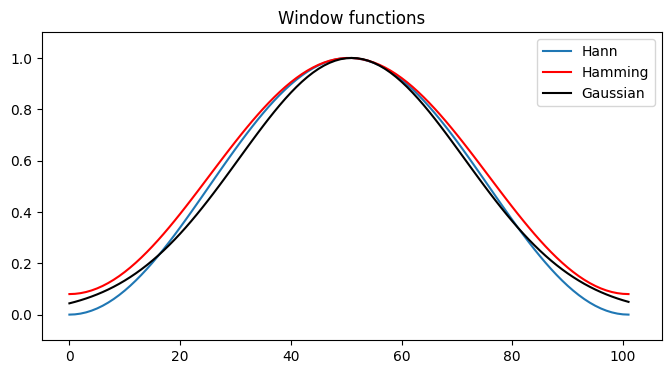

In [36]:
# Create Hamming and Hann windows
hamming_win = 0.54 - 0.46 * np.cos(2 * np.pi * np.arange(timewinidx) / (timewinidx - 1))
hann_win = 0.5 * (1 - np.cos(2 * np.pi * np.arange(timewinidx) / (timewinidx - 1)))

# Create Gaussian window
gaus_win = np.exp(-0.5 * ((2.5 * np.arange(-timewinidx / 2, timewinidx / 2)) / (timewinidx / 2)) ** 2)

# Plot together
plt.figure(figsize=(8, 4))
plt.plot(hann_win, label='Hann')
plt.plot(hamming_win, 'r', label='Hamming')
plt.plot(gaus_win, 'k', label='Gaussian')
plt.legend()
plt.xlim([-5, timewinidx + 5])
plt.ylim([-0.1, 1.1])
plt.yticks(np.arange(0, 1.1, 0.2))
plt.title('Window functions')
plt.show()

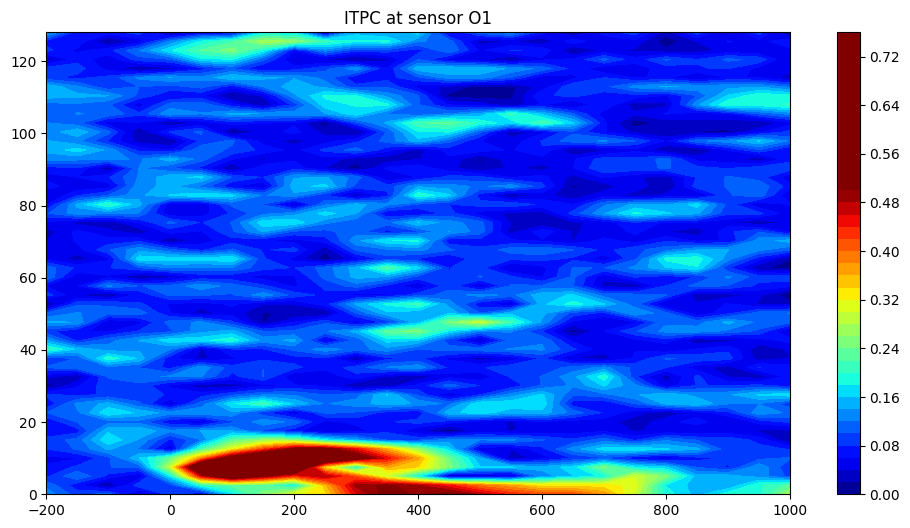

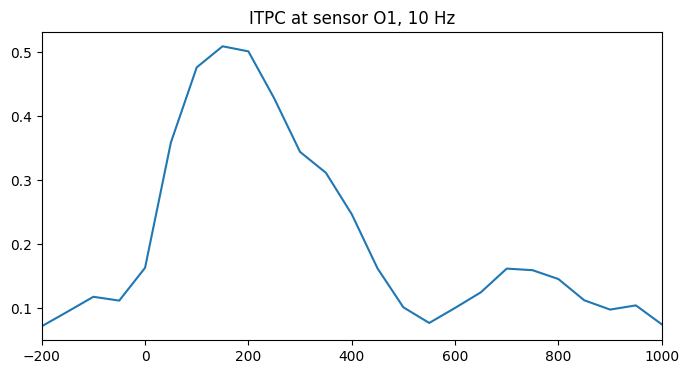

In [39]:
# Define parameters for Figure 15.6
chan2use = 'O1'
frequency2plot = 10  # in Hz

# Find the index of the frequency to plot
freq2plotidx = np.argmin(np.abs(frex - frequency2plot))

# Initialize ITPC output matrix
itpc = np.zeros((len(frex), len(times2save)))

# Loop over time points and perform FFT
for timepointi, tidx in enumerate(times2saveidx):
    # Extract time series data for this center time point
    tempdat = EEG['data'][np.where(np.array([ch['labels'][0] for ch in EEG['chanlocs'][0]]) == chan2use)[0][0],
                         tidx - int(np.floor(timewinidx / 2)) - 1:tidx + int(np.floor(timewinidx / 2)) - (timewinidx + 1) % 2, :]
    # Taper data
    taperdat = tempdat * hann_win[:, None]
    # Perform FFT
    fdat = fft(taperdat, axis=0) / timewinidx
    # Compute ITPC
    itpc[:, timepointi] = np.abs(np.mean(np.exp(1j * np.angle(fdat[0:int(np.floor(timewinidx / 2)) + 1, :])), axis=1))  # Average over trials

# Plot ITPC
plt.figure(figsize=(12, 6))
plt.contourf(times2save, frex, itpc, 40, cmap='jet', linestyles='None')
plt.colorbar()
plt.clim([0, 0.5])
plt.xlim([-200, 1000])
plt.title(f'ITPC at sensor {chan2use}')

plt.figure(figsize=(8, 4))
plt.plot(times2save, np.mean(itpc[freq2plotidx - 2:freq2plotidx + 3, :], axis=0))
plt.title(f'ITPC at sensor {chan2use}, {frequency2plot} Hz')
plt.xlim([-200, 1000])
plt.show()